# Viola-Jones Algorithm for Face Detection
    
[논문 "Rapid Object Detection using a Boosted Cascade of Simple Features"](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=990517&casa_token=VebGDljCrt0AAAAA:MJ9IK_3JClMdhu8C1HIYYrEp15irsjaAsWq7U6x1623jVfMsGpgynhlIq9dazlZ9JVKu2KqYi08)     
[논문 "Robust real-time Face Detection"](https://link.springer.com/content/pdf/10.1023/B:VISI.0000013087.49260.fb.pdf)     

### 1. Integral Image
     
### 2. Haar-like features
    
### 3. Adaboost
    
### 4. Cascade


----

### 1. Integral Image

Haar-like feature를 사용해 각 구역의 pixel 합을 쉽게 계산하기 위해 Integral Image를 사용한다.    
    
* Integral Image 계산    
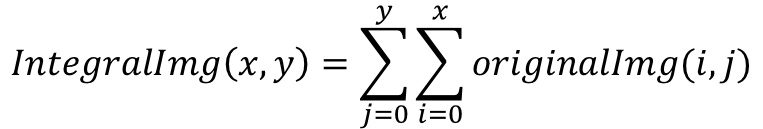

In [6]:
import numpy as np
array = np.arange(16).reshape((4,4))
print(array)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


In [7]:
integral_arr = np.cumsum(np.cumsum(array, axis=1), axis=0)
print(integral_arr)

[[  0   1   3   6]
 [  4  10  18  28]
 [ 12  27  45  66]
 [ 24  52  84 120]]


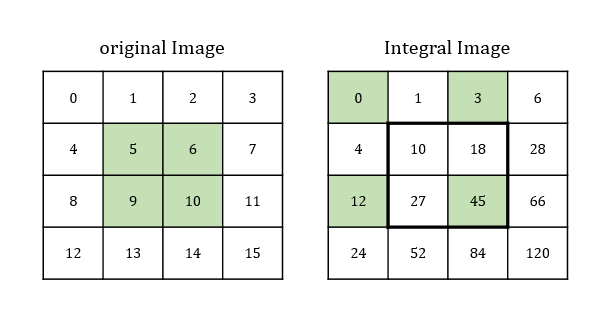     
original Image에서 색칠된 영역의 pixel 합은 Integral Image의 4개 pixel 값을 사용해 간단하게 계산된다.        
* original Image : 5+6+9+10
* Integral Image : 45-3-12+0

----
### 2. Haar-like features

얼굴에 존재하는 음양차이를 반영하는 feature 이다.   
white 영역과 black 영역의 값 차이가 feature value로 사용된다.     
* 3개 종류 및 5가지 형태의 haar-like feature
* 5가지 형태의 feature는 다양한 크기를 가질 수 있으며, 이미지에 따라 총 feature 수가 달라진다.
    
viola-jones 알고리즘은 AdaBoost를 사용하는데 Haar-like feature가 weak learner의 역할을 한다.

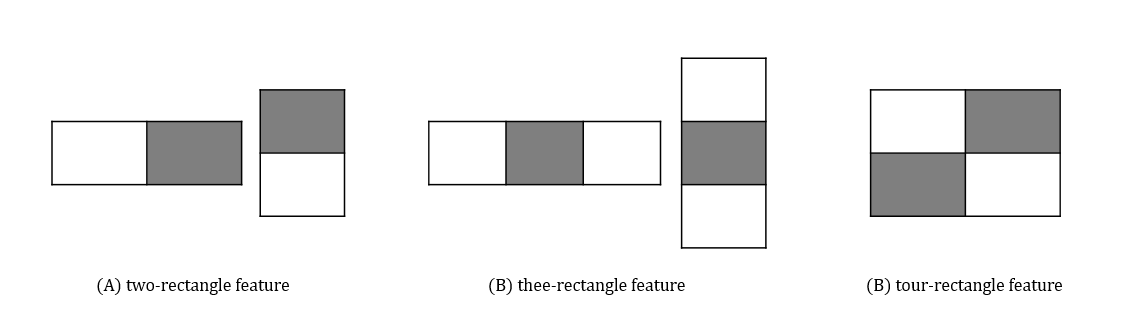

In [13]:
# 이미지 크기가 (15,15)일 때 총 feature 수를 알아보자
# feature : (A)는 (2,1), (1,2) / (B)는 (3,1), (1,3) / (C)는 (2,2)

img_size = (15,15)
cnt_features = 0

f_types = [(2,1), (1,2), (3,1), (1,3), (2,2)]
for ft in f_types:
    min_h = ft[0]
    min_w = ft[1]
    max_h = img_size[0]
    max_w = img_size[1]

    for w in range(min_w, max_w+1, ft[1]):
        for h in range(min_h, max_h+1, ft[0]):
            # position of feature
            for y in range(img_size[1]-w+1):
                for x in range(img_size[0]-h+1):
                    cnt_features += 1

print(cnt_features)

24976


In [20]:
from feature import create_features

# 각 feature의 최소 크기와 최대 크기를 설정할 수 있도록 구현.
features = create_features((15,15), "basic",  min_f_size=(2,2), max_f_size=(15,15))
print(len(features))

22246


* 15 x 15 이미지에서 생성될 수 있는 featue 수는 24,976개 이며, 24 x 24 이미지(논문 기준)라면 162,335개 feature가 생성된다.
* 최소 feature 크기를 (2,2)로 제한하면 그 수는 작아진다.

----
### 3. AdaBoost
    

* algorithm     
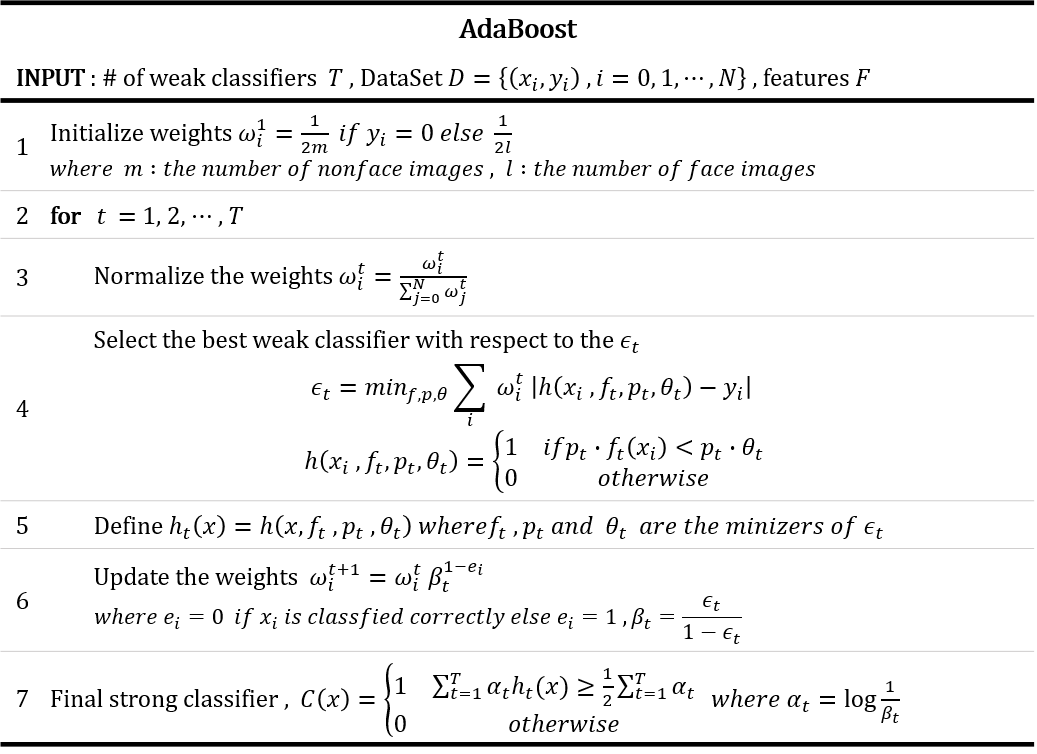

* weak classifier selection algorithm (Line 4)       
    train set : 
    $$(x_i, y_i)~for~i=1,2, ... , n$$
    $$where~x_i:image,~y_i:label~(0:nonface, 1:face)$$
    (1)  `n` 개 이미지에 대해 `t`번째 feature 값 계산하고 오름차순으로 정렬     
    (2)  (1)에서 정렬된 값들에 대해 error `e` 계산     
    $$\epsilon = min(S^+ +(T^- -S^-),~S^- +(T^+ -S^+))$$
    $$T^+:the~total~sum~of~face~image~weigths$$
    $$T^-:the~total~sum~of~nonface~image~weights$$
    $$S^+:the~sum~of~face~image~weights~below~the~current~image$$
    $$S^-:the~sum~of~nonface~image~weights~below~the~current~image$$
    
    (3)  가장 작은 `e` 갖는 feature 값을 `theta`로 지정, parity `p`는 위 수식의 min 함수에서 첫번째 항이 두번째 항보다 작은 경우 -1 그렇지않으면 1로 설정       
    (4) 모든 feature에 대해 (1)~(3) 과정을 수행하고 가장 작은 `e` 를 갖는 freature를 weak classifier로 선택한다.    
    
        
    

* 예제
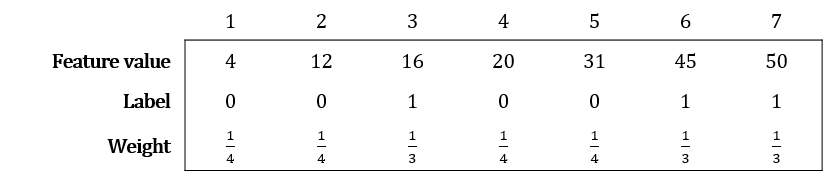      

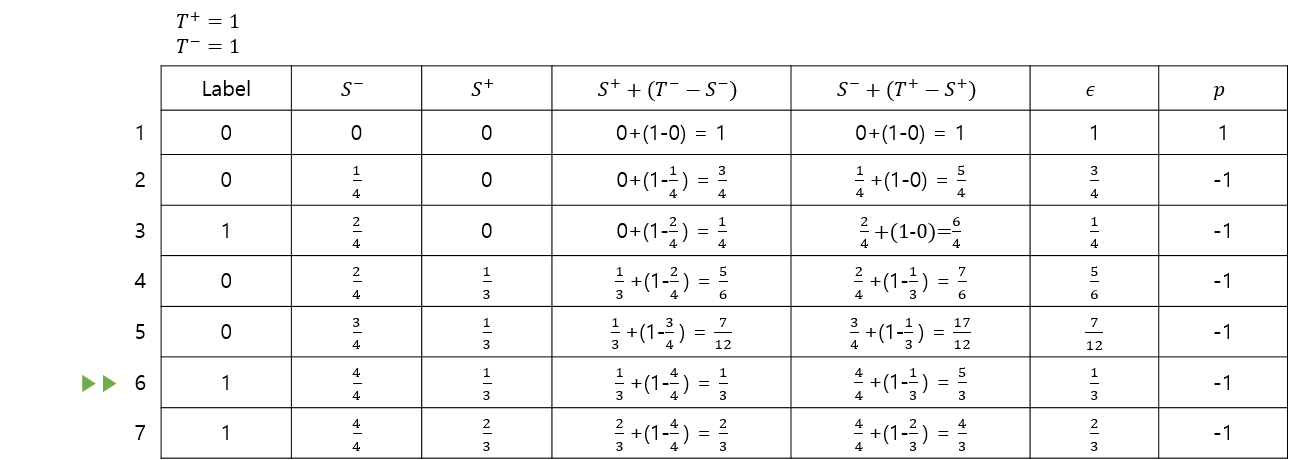

(+) 수식의 의미
$$\epsilon = min(S^+ +(T^- -S^-),~S^- +(T^+ -S^+))$$
            
첫 번째 항 :       
> Feature value `x`를 기준으로 작은 feature value는 0으로 예측하고 크거나 같으면 1로 예측.      
> 즉, `p`가 `-1` 인 경우를 의미한다.      
> 이 때, `x`보다 value가 작지만 실제 label이 1인 이미지는 분류를 잘 못 했다고 말할 수 있다. 반대의 경우도!   
>
> 따라서 `p`가 `-1` 이고 `x`를 기준으로 분류했을 때 발생하는 오분류된 이미지들의 weight 합이다.!      
           
두 번째 항 :       
> Feature value `x`를 기준으로 작은 feature value는 0으로 예측하고 크거나 같으면 1로 예측.     
> 즉, `p`가 `1` 인 경우를 의미한다.    
> 이 때, `x`보다 value가 작지만 실제 label이 0인 이미지는 분류를 잘 못 했다고 말할 수 있다. 반대의 경우도!   
>
> 따라서 `p`가 `1` 이고 `x`를 기준으로 분류했을 때 발생하는 오분류된 이미지들의 weight 합이다.!




----

### Implemetation

* dataset     
    MIT-CBCL dataset

In [ ]:
import random
import time
import utils
from feature import create_features, HaarFeature
import boosting
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
dir_face = ''
dir_non = ''

f_imgs = utils.load_img_float(dir_face)
n_imgs = utils.load_img_float(dir_non)

random.shuffle(f_imgs)
random.shuffle(n_imgs)

# integral Images with padding
f_train_iimgs = utils.integral_images(f_imgs[:1000], padding=True)
n_train_iimgs = utils.integral_images(n_imgs[:2000], padding=True)

# create features
featrues = create_features((19,19), 'basic', (1,1), (19,19))

# extracton - 각 img에 대한 feature value 미리 검사. (multiprocessing)
train_face = utils.data_extraction_mp(f_train_iimgs, 1, features, num_cores=4)
train_non = utils.data_extraction_mp(n_train_iimgs, 0, features, num_cores=4)

# run AdaBoost
model = boosting.AdaBoost(50)
model.train(train_face, train_non, features, isExtraction=True, verbose=True)


# Test data
f_test_iimgs = utils.integral_imgges(f_imgs[1000:], padding=True)
n_test_iimgs = utils.integral_imgges(n_imgs[2000:], padding=True)

pred_face = model.predict(f_test_iimgs)
pred_non = model.predict(n_test_iimgs)

preds = pred_face + pred_non
labels = np.ones(len(pred_face), dtype=np.int32).tolist() + np.zeros(len(pred_non), dtype=np.int32).tolist()
cf = confusion_matrix(labels, preds)

----
### Result

* train dataset : face image 1000개, nonface image 1000개     

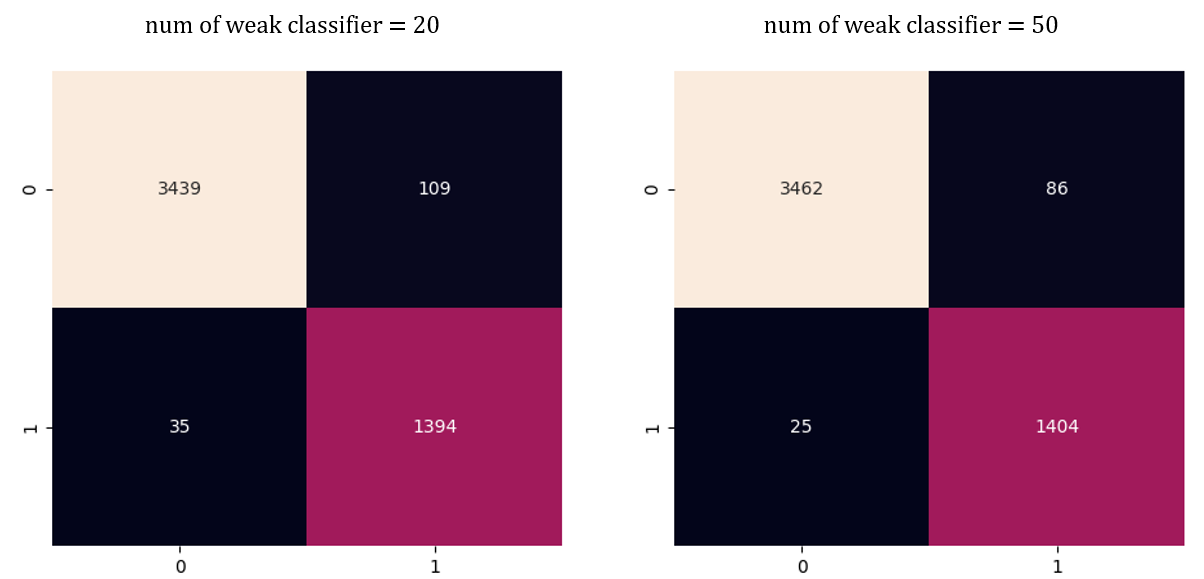
